In [1]:
import kagglehub
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from itertools import product


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

import time
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import pickle
from datetime import datetime

SEED = 123

## Download latest version
path = kagglehub.dataset_download("sameepvani/nasa-nearest-earth-objects")

/Users/theodorbjork/DD2368/DD2368/Project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv(f"{path}/neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
features = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance','absolute_magnitude']
target = 'hazardous'

In [4]:
df.iloc[[10,11]]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
10,54049873,(2020 OT6),0.252671,0.564989,58430.697200,3.833750e+07,Earth,False,20.11,True
11,54099949,(2020 XW4),0.152952,0.342011,64393.928316,7.198311e+07,Earth,False,21.20,False


In [5]:
mask = df[target] == True

In [6]:
N = 8840
np.random.seed(123)

df_true = df[df[target] == True]
df_false = df[df[target] == False]

df_subset_true = df_true.iloc[np.random.choice(N, size=N, replace=False)]
df_subset_false = df_false.iloc[np.random.choice(N, size=N, replace=False)]

df_subset = pd.concat([df_subset_true, df_subset_false])



In [7]:

from sklearn.model_selection import train_test_split

# Split the dataframe into 80% train and 20% test
train_df, test_df = train_test_split(
    df_subset,
    test_size=0.2,
    random_state=1,
    stratify=df_subset['hazardous']
)

# Optionally display the shapes of the train and test sets
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")



Train shape: (14144, 10)
Test shape: (3536, 10)


In [8]:
from sklearn.model_selection import train_test_split

# Split train_df further into 80% train and 20% validation, stratified on 'hazardous'
train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['hazardous']
)

# Optionally, print the shapes
print(f"Train split shape: {train_split_df.shape}")
print(f"Validation shape: {val_df.shape}")


Train split shape: (11315, 10)
Validation shape: (2829, 10)


In [9]:
train_split_df[features].head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
6870,0.201630,0.450858,50378.129004,4.473852e+07,20.60
40207,0.136319,0.304818,57258.634964,5.595927e+07,21.45
21865,0.133216,0.297879,79706.183096,1.037284e+07,21.50
70017,0.139494,0.311918,23500.785784,5.472054e+07,21.40
77140,0.160160,0.358129,79681.217623,1.548794e+07,21.10


In [10]:

X_train, Y_train = train_split_df[features].to_numpy(), train_split_df[target].apply(lambda x: int(x)).to_numpy()
X_val, Y_val = val_df[features].to_numpy(), val_df[target].apply(lambda x: int(x)).to_numpy()
X_test, Y_test = test_df[features].to_numpy(), test_df[target].apply(lambda x: int(x)).to_numpy()


In [11]:
y = np.where(Y_train==1, +1, -1)

# Make mean 0 and standard diviation 1
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_test)
# ---YOUR CODE ENDS HERE---

print("Shapes:", X_tr.shape, X_te.shape, " (+1 count):", (Y_train==+1).sum(), " (-1 count):", (Y_train==-1).sum())

Shapes: (11315, 5) (3536, 5)  (+1 count): 5657  (-1 count): 0


In [12]:
n_qubits = 5
SEED = 123

dev = qml.device("default.qubit", wires=n_qubits, shots=None, seed=SEED)

# @qml.qnode(dev)
def feature_map_angle1(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return None

def feature_map_qnn2(x, wires=None, scale=1.0, entangle=True):
    qml.IQPEmbedding(features=x, wires=wires, n_repeats=1, pattern=None)
    return None


# @qml.qnode(dev)
def feature_map_angle3(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        n = len(wires)
        for i in range(n):
            for j in range(i+1, n):
                qml.CZ([wires[i], wires[j]])
    # ---YOUR CODE ENDS HERE---
    return None
    
# @qml.qnode(dev)
# def all_bitstring_probabilities(x, z, scale=1.0, entangle=True):
#     # -----YOUR CODE HERE-----
#     feature_map_angle(x, wires=list(range(len(x))), scale = scale, entangle=entangle)
#     qml.adjoint(feature_map_angle)(z, wires=list(range(len(z))), scale=scale, entangle=entangle)
#     probs = qml.probs()
#     # ---YOUR CODE ENDS HERE---
#     return probs

# def overlap_probability(x, z, scale=1.0, entangle=True):
#     return all_bitstring_probabilities(x, z, scale=scale, entangle=entangle)[0]

# # Quick sanity check for x_5

# def quantum_kernel(A, B, scale=1.0, entangle=True):
#     # -----YOUR CODE HERE-----
#     tqdmA = tqdm(A)
#     K = np.array([[overlap_probability(a,b, scale=scale) for b in B] for a in tqdmA])
    
#     # ---YOUR CODE ENDS HERE---
#     return K

In [13]:
#K_tr_old = quantum_kernel(X_tr, X_tr)

In [14]:
# HYPERPARAMETERS


PCA_DIMS = [3,4,5]
FEATURE_MAPS = [feature_map_angle1, feature_map_qnn2, feature_map_angle3]


In [15]:
# ============================================
# QSVM GRID SEARCH
# ============================================

from sklearn.svm import SVC

results = {}
configs = list(product(PCA_DIMS, FEATURE_MAPS))

for pca_dim, feature_map in tqdm(configs, desc="QSVM Grid Search"):
    
    np.random.seed(SEED)
    
    print("=" * 60)
    print(f"Running: PCA_DIM={pca_dim}, FEATURE_MAP={feature_map.__name__}")
    
    # Create device with appropriate number of wires
    dev = qml.device("lightning.qubit", wires=pca_dim)
    
    # Apply PCA
    pca = PCA(n_components=pca_dim).fit(X_tr)
    X_tr_red = pca.transform(X_tr)
    X_val_red = pca.transform(X_val)
    X_te_red = pca.transform(X_te)
    
    # Define the feature map circuit for this configuration
    @qml.qnode(dev)
    def feature_map_circuit(x):
        feature_map(x, wires=list(range(pca_dim)))
        return qml.state()
    
    # Compute state vectors for training data
    print("  Computing training state vectors...")
    start_time = time.time()
    X_states_tr = np.stack([feature_map_circuit(x) for x in tqdm(X_tr_red, desc="  Train states", leave=False)])
    train_state_time = time.time() - start_time
    print(f"  Training states computed in {train_state_time:.2f}s")
    
    # Compute kernel matrix for training data (K_train)
    print("  Computing training kernel matrix...")
    start_time = time.time()
    K_train = np.empty((X_states_tr.shape[0], X_states_tr.shape[0]), dtype=np.float32)
    for i, psi_i in enumerate(tqdm(X_states_tr, desc="  K_train", leave=False)):
        K_train[i, :] = np.abs(np.dot(X_states_tr, psi_i.conj()))**2
    train_kernel_time = time.time() - start_time
    print(f"  Training kernel computed in {train_kernel_time:.2f}s")
    
    # Compute state vectors for validation data
    print("  Computing validation state vectors...")
    X_states_val = np.stack([feature_map_circuit(x) for x in tqdm(X_val_red, desc="  Val states", leave=False)])
    
    # Compute kernel matrix for validation vs training (K_val)
    print("  Computing validation kernel matrix...")
    K_val = np.empty((X_states_val.shape[0], X_states_tr.shape[0]), dtype=np.float32)
    for i, psi_i in enumerate(tqdm(X_states_val, desc="  K_val", leave=False)):
        K_val[i, :] = np.abs(np.dot(X_states_tr, psi_i.conj()))**2
    
    # Compute state vectors for test data
    print("  Computing test state vectors...")
    X_states_te = np.stack([feature_map_circuit(x) for x in tqdm(X_te_red, desc="  Test states", leave=False)])
    
    # Compute kernel matrix for test vs training (K_test)
    print("  Computing test kernel matrix...")
    K_test = np.empty((X_states_te.shape[0], X_states_tr.shape[0]), dtype=np.float32)
    for i, psi_i in enumerate(tqdm(X_states_te, desc="  K_test", leave=False)):
        K_test[i, :] = np.abs(np.dot(X_states_tr, psi_i.conj()))**2
    
    # Train SVM with precomputed kernel
    print("  Training SVM...")
    start_time = time.time()
    svm = SVC(kernel='precomputed')
    svm.fit(K_train, Y_train)
    svm_train_time = time.time() - start_time
    print(f"  SVM trained in {svm_train_time:.2f}s")
    
    # Evaluate on validation set
    y_pred_val = svm.predict(K_val)
    val_acc = accuracy_score(Y_val, y_pred_val)
    
    # Evaluate on test set
    y_pred_test = svm.predict(K_test)
    test_acc = accuracy_score(Y_test, y_pred_test)
    cm = confusion_matrix(Y_test, y_pred_test)
    
    # ROC-AUC (using decision function)
    y_scores_test = svm.decision_function(K_test)
    roc_auc = roc_auc_score(Y_test, y_scores_test)
    
    print(f"  Validation Accuracy: {val_acc:.3f}")
    print(f"  Test Accuracy: {test_acc:.3f}")
    print(f"  ROC-AUC: {roc_auc:.3f}")
    print("  Confusion Matrix:")
    print(cm)
    print(classification_report(Y_test, y_pred_test))
    
    # Save results
    config_key = f"{pca_dim}_{feature_map.__name__}"
    results[config_key] = {
        "pca_dim": pca_dim,
        "feature_map": feature_map.__name__,
        "val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "roc_auc": float(roc_auc),
        "confusion_matrix": cm.tolist(),
        "classification_report": classification_report(Y_test, y_pred_test, output_dict=True),
        "train_state_time": train_state_time,
        "train_kernel_time": train_kernel_time,
        "svm_train_time": svm_train_time,
    }
    
    # Save intermediate results
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")
    results_filename = f"INCOMPLETE_qsvm_grid_search_results_{timestamp}.pkl"
    with open(results_filename, "wb") as f:
        pickle.dump(results, f)
    print(f"  Results saved to {results_filename}")

# Save final results
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
results_filename = f"qsvm_grid_search_results_{timestamp}.pkl"
with open(results_filename, "wb") as f:
    pickle.dump(results, f)

print(f"\n{'='*60}")
print(f"GRID SEARCH COMPLETE! Results saved to {results_filename}")
print(f"{'='*60}")

# Print summary
print("\nSummary of Results:")
print("-" * 40)
for key, res in results.items():
    print(f"{key}: Test Acc={res['test_accuracy']:.3f}, ROC-AUC={res['roc_auc']:.3f}")

QSVM Grid Search:   0%|          | 0/9 [00:00<?, ?it/s]

Running: PCA_DIM=3, FEATURE_MAP=feature_map_angle1
  Computing training state vectors...


  Training states computed in 6.65s
  Computing training kernel matrix...


  Training kernel computed in 1.52s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 1.08s


QSVM Grid Search:  11%|█         | 1/9 [00:13<01:50, 13.86s/it]

  Validation Accuracy: 0.811
  Test Accuracy: 0.801
  ROC-AUC: 0.836
  Confusion Matrix:
[[1240  528]
 [ 177 1591]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1768
           1       0.75      0.90      0.82      1768

    accuracy                           0.80      3536
   macro avg       0.81      0.80      0.80      3536
weighted avg       0.81      0.80      0.80      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172436.pkl
Running: PCA_DIM=3, FEATURE_MAP=feature_map_qnn2
  Computing training state vectors...


  Training states computed in 5.37s
  Computing training kernel matrix...


  Training kernel computed in 1.89s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.91s


QSVM Grid Search:  22%|██▏       | 2/9 [00:26<01:31, 13.02s/it]

  Validation Accuracy: 0.790
  Test Accuracy: 0.788
  ROC-AUC: 0.821
  Confusion Matrix:
[[1171  597]
 [ 152 1616]]
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1768
           1       0.73      0.91      0.81      1768

    accuracy                           0.79      3536
   macro avg       0.81      0.79      0.78      3536
weighted avg       0.81      0.79      0.78      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172449.pkl
Running: PCA_DIM=3, FEATURE_MAP=feature_map_angle3
  Computing training state vectors...


  Training states computed in 5.75s
  Computing training kernel matrix...


  Training kernel computed in 1.85s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.82s


QSVM Grid Search:  33%|███▎      | 3/9 [00:39<01:18, 13.03s/it]

  Validation Accuracy: 0.811
  Test Accuracy: 0.801
  ROC-AUC: 0.836
  Confusion Matrix:
[[1240  528]
 [ 177 1591]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1768
           1       0.75      0.90      0.82      1768

    accuracy                           0.80      3536
   macro avg       0.81      0.80      0.80      3536
weighted avg       0.81      0.80      0.80      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172502.pkl
Running: PCA_DIM=4, FEATURE_MAP=feature_map_angle1
  Computing training state vectors...


  Training states computed in 6.07s
  Computing training kernel matrix...


  Training kernel computed in 2.57s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.86s


QSVM Grid Search:  44%|████▍     | 4/9 [00:54<01:08, 13.73s/it]

  Validation Accuracy: 0.824
  Test Accuracy: 0.817
  ROC-AUC: 0.852
  Confusion Matrix:
[[1177  591]
 [  55 1713]]
              precision    recall  f1-score   support

           0       0.96      0.67      0.78      1768
           1       0.74      0.97      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.85      0.82      0.81      3536
weighted avg       0.85      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172516.pkl
Running: PCA_DIM=4, FEATURE_MAP=feature_map_qnn2
  Computing training state vectors...


  Training states computed in 5.72s
  Computing training kernel matrix...


  Training kernel computed in 2.37s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.86s


QSVM Grid Search:  56%|█████▌    | 5/9 [01:08<00:55, 13.81s/it]

  Validation Accuracy: 0.820
  Test Accuracy: 0.815
  ROC-AUC: 0.846
  Confusion Matrix:
[[1184  584]
 [  70 1698]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1768
           1       0.74      0.96      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.84      0.82      0.81      3536
weighted avg       0.84      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172530.pkl
Running: PCA_DIM=4, FEATURE_MAP=feature_map_angle3
  Computing training state vectors...


  Training states computed in 6.81s
  Computing training kernel matrix...


  Training kernel computed in 2.50s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 1.47s


QSVM Grid Search:  67%|██████▋   | 6/9 [01:24<00:44, 14.80s/it]

  Validation Accuracy: 0.824
  Test Accuracy: 0.817
  ROC-AUC: 0.852
  Confusion Matrix:
[[1177  591]
 [  55 1713]]
              precision    recall  f1-score   support

           0       0.96      0.67      0.78      1768
           1       0.74      0.97      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.85      0.82      0.81      3536
weighted avg       0.85      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172547.pkl
Running: PCA_DIM=5, FEATURE_MAP=feature_map_angle1
  Computing training state vectors...


  Training states computed in 6.49s
  Computing training kernel matrix...


  Training kernel computed in 2.55s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.96s


QSVM Grid Search:  78%|███████▊  | 7/9 [01:40<00:30, 15.01s/it]

  Validation Accuracy: 0.824
  Test Accuracy: 0.817
  ROC-AUC: 0.852
  Confusion Matrix:
[[1177  591]
 [  55 1713]]
              precision    recall  f1-score   support

           0       0.96      0.67      0.78      1768
           1       0.74      0.97      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.85      0.82      0.81      3536
weighted avg       0.85      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172603.pkl
Running: PCA_DIM=5, FEATURE_MAP=feature_map_qnn2
  Computing training state vectors...


  Training states computed in 6.02s
  Computing training kernel matrix...


  Training kernel computed in 3.33s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.86s


QSVM Grid Search:  89%|████████▉ | 8/9 [01:55<00:15, 15.12s/it]

  Validation Accuracy: 0.820
  Test Accuracy: 0.815
  ROC-AUC: 0.846
  Confusion Matrix:
[[1184  584]
 [  70 1698]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1768
           1       0.74      0.96      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.84      0.82      0.81      3536
weighted avg       0.84      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172618.pkl
Running: PCA_DIM=5, FEATURE_MAP=feature_map_angle3
  Computing training state vectors...


  Training states computed in 7.51s
  Computing training kernel matrix...


  Training kernel computed in 2.66s
  Computing validation state vectors...


  Computing validation kernel matrix...


  Computing test state vectors...


  Computing test kernel matrix...


  Training SVM...
  SVM trained in 0.98s


QSVM Grid Search: 100%|██████████| 9/9 [02:13<00:00, 14.79s/it]

  Validation Accuracy: 0.824
  Test Accuracy: 0.817
  ROC-AUC: 0.852
  Confusion Matrix:
[[1177  591]
 [  55 1713]]
              precision    recall  f1-score   support

           0       0.96      0.67      0.78      1768
           1       0.74      0.97      0.84      1768

    accuracy                           0.82      3536
   macro avg       0.85      0.82      0.81      3536
weighted avg       0.85      0.82      0.81      3536

  Results saved to INCOMPLETE_qsvm_grid_search_results_20251228_172635.pkl

GRID SEARCH COMPLETE! Results saved to qsvm_grid_search_results_20251228_172635.pkl

Summary of Results:
----------------------------------------
3_feature_map_angle1: Test Acc=0.801, ROC-AUC=0.836
3_feature_map_qnn2: Test Acc=0.788, ROC-AUC=0.821
3_feature_map_angle3: Test Acc=0.801, ROC-AUC=0.836
4_feature_map_angle1: Test Acc=0.817, ROC-AUC=0.852
4_feature_map_qnn2: Test Acc=0.815, ROC-AUC=0.846
4_feature_map_angle3: Test Acc=0.817, ROC-AUC=0.852
5_feature_map_angle1: Test 

In [16]:
@qml.qnode(dev)
def feature_map_angle(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return qml.state()









    

In [17]:
X_pre = np.stack([feature_map_angle(x, wires=list(range(len(x)))) for x in tqdm(X_tr)])

100%|██████████| 11315/11315 [00:06<00:00, 1809.80it/s]


In [18]:
# Compute the kernel matrix in a memory-efficient way (row by row)
k = np.empty((X_pre.shape[0], X_pre.shape[0]), dtype=np.float32)
a = tqdm(X_pre)
for i, psi_i in enumerate(a):
    dot_products = np.abs(np.dot(X_pre, psi_i.conj()))**2
    k[i, :] = dot_products


100%|██████████| 11315/11315 [00:02<00:00, 4255.49it/s]


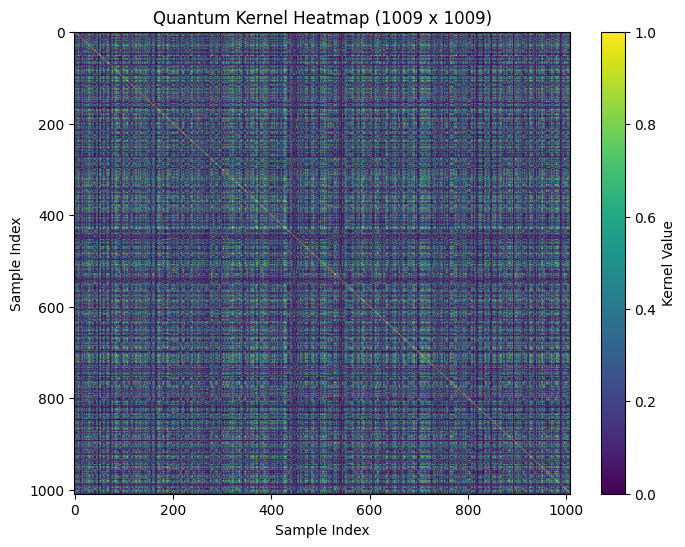

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a central submatrix (e.g., 200x200) of the kernel with a heatmap
N = 1009
if k.shape[0] > N:
    start = k.shape[0] // 2 - N // 2
    end = start + N
    k_vis = k[start:end, start:end]
else:
    k_vis = k

plt.figure(figsize=(8, 6))
plt.imshow(k_vis, cmap='viridis', aspect='auto')
plt.colorbar(label='Kernel Value')
plt.title(f'Quantum Kernel Heatmap ({k_vis.shape[0]} x {k_vis.shape[1]})')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()


In [20]:
X_pre_val = np.stack([feature_map_angle(x, wires=list(range(len(x)))) for x in tqdm(X_val)])

100%|██████████| 2829/2829 [00:01<00:00, 1815.99it/s]


In [21]:
# Compute the kernel matrix in a memory-efficient way (row by row)
k_tr_val = np.empty((X_pre_val.shape[0], X_pre.shape[0]), dtype=np.float32)
a = tqdm(X_pre_val)
for i, psi_i in enumerate(a):
    dot_products = np.abs(np.dot(X_pre, psi_i.conj()))**2
    k_tr_val[i, :] = dot_products

100%|██████████| 2829/2829 [00:00<00:00, 4180.37it/s]


In [22]:
import pickle

# Save X_train, X_val, X_test, Y_train, Y_val, Y_test
with open("features_labels.pkl", "wb") as f:
    pickle.dump({
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_val": Y_val,
        "Y_test": Y_test
    }, f)

# Save k and k_tr_val
with open("kernels.pkl", "wb") as f:
    pickle.dump({
        "k": k,
        "k_tr_val": k_tr_val
    }, f)


In [23]:
import pickle

# Load all previously saved data (features_labels.pkl and kernels.pkl)
with open("features_labels.pkl", "rb") as f:
    features_labels = pickle.load(f)
    X_train = features_labels["X_train"]
    X_val = features_labels["X_val"]
    X_test = features_labels["X_test"]
    Y_train = features_labels["Y_train"]
    Y_val = features_labels["Y_val"]
    Y_test = features_labels["Y_test"]

with open("kernels.pkl", "rb") as f:
    kernels = pickle.load(f)
    k = kernels["k"]
    k_tr_val = kernels["k_tr_val"]


              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1414
           1       0.75      0.99      0.86      1415

    accuracy                           0.83      2829
   macro avg       0.87      0.83      0.83      2829
weighted avg       0.87      0.83      0.83      2829

Confusion Matrix:
[[ 957  457]
 [  12 1403]]


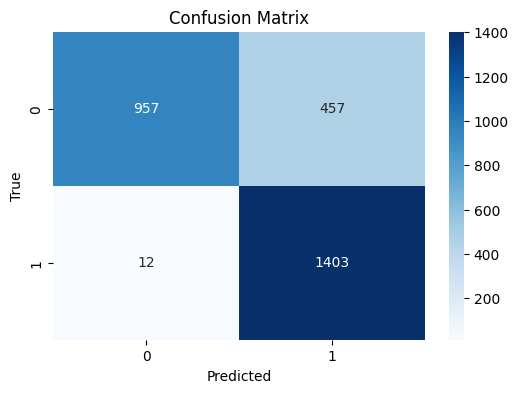

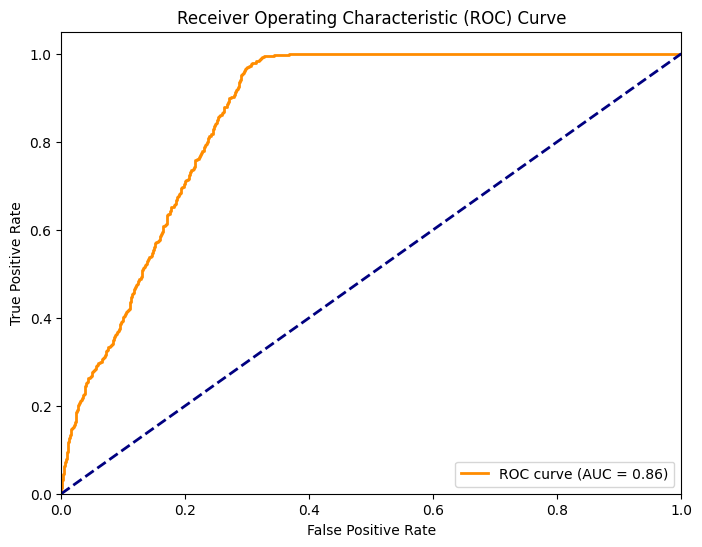

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM on the precomputed kernel (k)
svm = SVC(kernel='precomputed')
svm.fit(k, Y_train)

# Predict on validation set using k_tr_val
y_pred = svm.predict(k_tr_val)

# Print classification report
print(classification_report(Y_val, y_pred))


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(Y_val, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix for better visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the positive class (assuming binary classification)
# SVC does not have predict_proba by default with precomputed kernels but has decision_function
y_scores = svm.decision_function(k_tr_val)

fpr, tpr, thresholds = roc_curve(Y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [25]:
# # Compare elements of k and k_tr_old to check if they are equal or to what extent they're similar

# import numpy as np

# # Check if the variables k and k_tr_old exist
# if 'k' in locals() and 'K_tr_old' in locals():
#     # For exact equality (numerical precision considered)
#     arrays_equal = np.array_equal(k, K_tr_old)
#     print(f"Are k and k_tr_old exactly equal? {arrays_equal}")

#     # For floating point arrays, use np.allclose to account for numerical precision tolerance
#     arrays_close = np.allclose(k, K_tr_old)
#     print(f"Are k and k_tr_old numerically close? {arrays_close}")

#     # If not equal or close, show some summary statistics
#     if not arrays_close:
#         diff = np.abs(k - K_tr_old)
#         print(f"Max absolute difference: {np.max(diff)}")
#         print(f"Mean absolute difference: {np.mean(diff)}")
#         print(f"Min absolute difference: {np.min(diff)}")
# else:
#     print("Either 'k' or 'k_tr_old' is not defined in the current context.")
